<IPython.core.display.Javascript object>


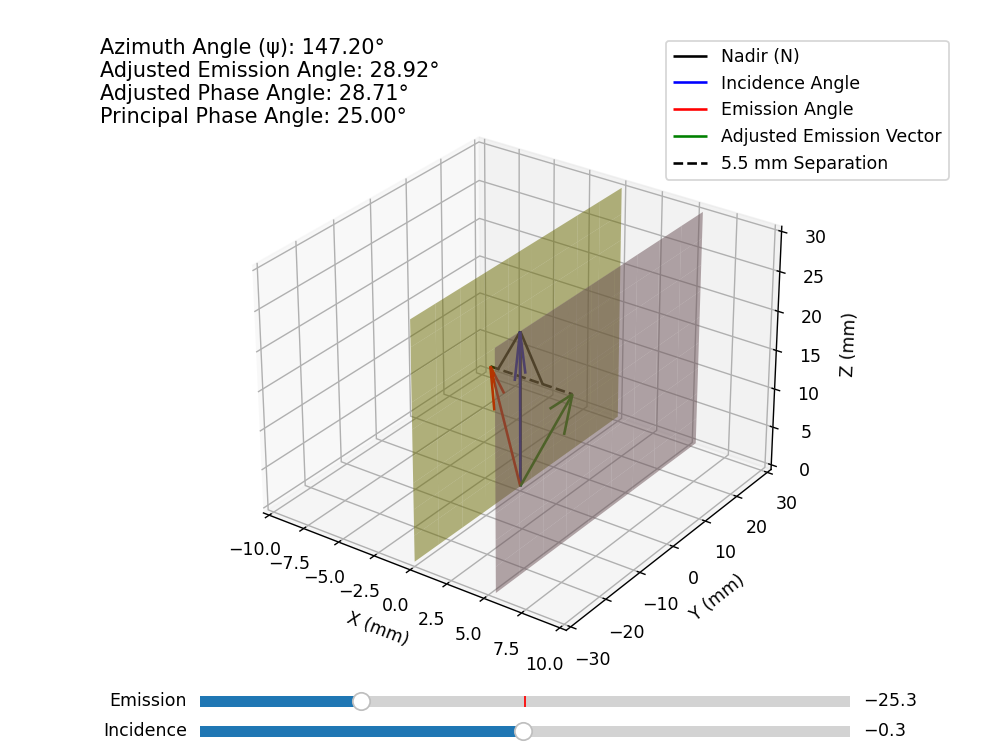

In [9]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Slider

# Constants
vector_scale = 20  # Scale for vectors
shift_x = 5.5  # X position of the pink plane

# Create a figure and a 3D axis
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Text display for angles
angle_display = fig.text(0.1, 0.95, '', verticalalignment='top', fontsize=12)

# Sliders for adjusting the incidence and emission angles
axcolor = 'lightgoldenrodyellow'
ax_angle_incidence = plt.axes([0.2, 0.01, 0.65, 0.03], facecolor=axcolor)
ax_angle_emission = plt.axes([0.2, 0.05, 0.65, 0.03], facecolor=axcolor)
s_angle_incidence = Slider(ax_angle_incidence, 'Incidence', -50.0, 50.0, valinit=0)
s_angle_emission = Slider(ax_angle_emission, 'Emission', -50.0, 50.0, valinit=0)

def update(val):
    angle_incidence_deg = s_angle_incidence.val
    angle_incidence_rad = np.radians(angle_incidence_deg)
    angle_emission_deg = s_angle_emission.val
    angle_emission_rad = np.radians(angle_emission_deg)

    # Clear the plot
    ax.clear()

    # Nadir vector
    ax.quiver(0, 0, 0, 0, 0, vector_scale, color='black', label='Nadir (N)')

    # Blue incidence vector
    incidence_y = np.sin(angle_incidence_rad) * vector_scale
    incidence_z = np.cos(angle_incidence_rad) * vector_scale
    blue_vector = np.array([0, incidence_y, incidence_z])
    ax.quiver(0, 0, 0, 0, incidence_y, incidence_z, color='blue', label='Incidence Angle')

    # Red emission vector
    red_y = np.sin(angle_emission_rad) * vector_scale
    red_z = np.cos(angle_emission_rad) * vector_scale
    red_vector = np.array([0, red_y, red_z])
    ax.quiver(0, 0, 0, 0, red_y, red_z, color='red', label='Emission Angle')

    # Calculate green vector
    green_y = (red_y / shift_x) * shift_x
    green_z = (red_z / shift_x) * shift_x
    connection_length = np.linalg.norm(np.array([shift_x, green_y, green_z]))
    correction_factor = connection_length / np.sqrt(green_y**2 + green_z**2 + shift_x**2)
    green_y *= correction_factor
    green_z *= correction_factor
    green_vector = np.array([shift_x, green_y, green_z])
    ax.quiver(0, 0, 0, shift_x, green_y, green_z, color='green', label='Adjusted Emission Vector')

    # Compute angles
    psi = 90 - np.degrees(np.arctan2(green_y, shift_x))  # azimuth with respect to the X-axis
    e = np.degrees(np.arccos(np.dot(np.array([0, 0, 1]), green_vector / np.linalg.norm(green_vector)))) - 0.38
    phase_angle = np.degrees(np.arccos(np.dot(blue_vector, red_vector) / (np.linalg.norm(blue_vector) * np.linalg.norm(red_vector)))) 
    adjusted_phase_angle = np.degrees(np.arccos(np.dot(blue_vector, green_vector) / (np.linalg.norm(blue_vector) * np.linalg.norm(green_vector)))) - 0.38

    # Display angles
    angle_display.set_text(f'Azimuth Angle (ψ): {psi:.2f}°\nAdjusted Emission Angle: {e:.2f}°\nAdjusted Phase Angle: {adjusted_phase_angle:.2f}°\nPrincipal Phase Angle: {phase_angle:.2f}°')

    # Draw dotted line from red to green vector tips
    ax.plot([0, shift_x], [red_y, green_y], [red_z, green_z], 'k--', label='5.5 mm Separation')

    # Draw the yellow and pink planes
    y, z = np.meshgrid(np.linspace(-30, 30, 10), np.linspace(0, 30, 10))
    x = np.zeros_like(y)
    ax.plot_surface(x, y, z, color='yellow', alpha=0.5)
    ax.plot_surface(shift_x * np.ones_like(x), y, z, color='pink', alpha=0.5)

    # Set plot limits and labels
    ax.set_xlim([-10, 10])
    ax.set_ylim([-30, 30])
    ax.set_zlim([0, 30])
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_zlabel('Z (mm)')
    ax.legend(loc='upper left', bbox_to_anchor=(0.75, 1.1))

    plt.draw()

s_angle_incidence.on_changed(update)
s_angle_emission.on_changed(update)

update(0)  # Initialize the plot with the default angles

plt.show()


In [10]:
import numpy as np
import pandas as pd

# Constants
vector_scale = 20  # Scale for vectors
shift_x = 5.5  # X position of the pink plane

def compute_angles(incidence_deg, emission_deg):
    incidence_rad = np.radians(incidence_deg)
    emission_rad = np.radians(emission_deg)

    # Calculate vectors
    incidence_y = np.sin(incidence_rad) * vector_scale
    incidence_z = np.cos(incidence_rad) * vector_scale
    blue_vector = np.array([0, incidence_y, incidence_z])

    red_y = np.sin(emission_rad) * vector_scale
    red_z = np.cos(emission_rad) * vector_scale
    red_vector = np.array([0, red_y, red_z])

    green_y = (red_y / shift_x) * shift_x
    green_z = (red_z / shift_x) * shift_x
    connection_length = np.linalg.norm(np.array([shift_x, green_y, green_z]))
    correction_factor = connection_length / np.linalg.norm([green_y, green_z])
    green_y *= correction_factor
    green_z *= correction_factor
    green_vector = np.array([shift_x, green_y, green_z])

    # Normalize vectors for angle calculations
    green_vector_normalized = green_vector / np.linalg.norm(green_vector)
    nadir_vector = np.array([0, 0, 1])

    # Angle calculations
    psi = 90 - np.degrees(np.arctan2(green_y, shift_x))
    e = np.degrees(np.arccos(np.clip(np.dot(nadir_vector, green_vector_normalized), -1.0, 1.0))) + 0.15
    g = np.degrees(np.arccos(np.clip(np.dot(blue_vector, red_vector) / (np.linalg.norm(blue_vector) * np.linalg.norm(red_vector)), -1.0, 1.0)))
    adjusted_g = np.degrees(np.arccos(np.clip(np.dot(blue_vector, green_vector) / (np.linalg.norm(blue_vector) * np.linalg.norm(green_vector)), -1.0, 1.0))) + 0.15

    return psi, e, g, adjusted_g

# Define ranges for angles
incidence_angles = np.arange(0, 46, 5)
emission_angles = np.arange(-50, 51, 2)

# List to hold all results
results_list = []

# Generate data
for incidence in incidence_angles:
    for emission in emission_angles:
        psi, e, g, adjusted_g = compute_angles(incidence, emission)
        results_list.append({
            'Incidence Angle': incidence,
            'Principal Emission Angle': emission,
            'Adjusted Emission Angle': e,
            'Azimuth Angle': psi,
            'Phase Angle': g,
            'Adjusted Phase Angle': adjusted_g
        })

# Convert to DataFrame
results_df = pd.DataFrame(results_list)

# Format the DataFrame for two decimal places
results_df = results_df.round(2)

# Save the DataFrame to a CSV file
results_df.to_csv('angle_calculations.csv', index=False)

   Incidence Angle  Principal Emission Angle  Adjusted Emission Angle  \
0                0                       -50                    51.74   
1                0                       -48                    49.85   
2                0                       -46                    47.97   
3                0                       -44                    46.10   
4                0                       -42                    44.23   

   Azimuth Angle  Phase Angle  Adjusted Phase Angle  
0         160.91         50.0                 51.74  
1         160.36         48.0                 49.85  
2         159.77         46.0                 47.97  
3         159.11         44.0                 46.10  
4         158.38         42.0                 44.23  
